#Final Project for Data Wrangling with MongoDB
Cynthia O'Donnell

Objective: Audit and clean the data set, convert data from XML to JSON, input to MongoDB database and run queries against the database.

Honor code statement:

*“I, Cynthia O'Donnell, hereby confirm that this submission is my own work.  I have cited above the origins of any parts of the submission that were taken from websites, books, forums, blog posts, Github repositories, etc. By including this in my project report, I understand that I will be expected to explain my work in a video call with a Udacity coach before I can receive my verified certificate.”*

##Data Overview
- Location: Richmond, Virginia
- [Original Data](https://github.com/mimibambino/DAND_P2/richmond_virginia.osm)
- Data size: `114.9 MB`
- JSON data size: `130.3 MB`

I began the audit by running the `count_tags()` function.  It creates a Python dictionary of all the tags contained in the xml file.

In [1]:
import xml.etree.ElementTree as ET
import pprint
filename = "richmond_virginia.osm"

def count_tags(filename):
    tags = {}
    for _, element in ET.iterparse(filename, events=("start",)):
        if element.tag in tags:
            tags[element.tag] += 1
        else:
            tags[element.tag] = 1
    return tags

pprint.pprint(count_tags(filename))

{'bounds': 1,
 'member': 3101,
 'nd': 603849,
 'node': 523670,
 'osm': 1,
 'relation': 410,
 'tag': 293571,
 'way': 49326}


In order to input this data to MongoDB, I need to determine what the keys to use.  There are many `<node>` and `<way>` tags in this data and these tags have a `k` attribute.  This next code determines whether the k values would be valid keys in MongoDB.  

In order to do this we use 3 regular expressions to check for certain patterns
in the `k` attributes.

In [4]:
import xml.etree.ElementTree as ET
import pprint
import re
"""
Determine whether the "k" value for each "<tag>" can be a valid key in MongoDB.
"""

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


def key_type(element, keys):
    if element.tag == "tag":
        k = element.attrib['k']
        if lower.search(k):
            keys["lower"] += 1
        elif lower_colon.search(k):
            keys["lower_colon"] += 1
        elif problemchars.search(k):
            keys["problemchars"] += 1
        else:
            keys["other"] += 1
        
    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

keys = process_map(filename)
pprint.pprint(keys)

{'lower': 118144, 'lower_colon': 168747, 'other': 6677, 'problemchars': 3}


This output tells us that our function classifies most tags as `lower` or `lower_colon`.  Three of the tags were classified as `problemchars`, and 6677 tags were classified as `other`.  I would like to investigate the `problemchars` tags further. 

In [4]:
def print_problems(filename):
    for _, element in ET.iterparse(filename):
        if element.tag == "tag":
            k = element.attrib["k"]
            if lower.search(k):
                pass
            elif lower_colon.search(k):
                pass
            elif problemchars.search(k):
                print "problem: " + k
                print element.attrib

print_problems(filename)

problem: commit message
{'k': 'commit message', 'v': '#osmgeoweek #GisNova'}
problem: commit message
{'k': 'commit message', 'v': '#osmgeoweek #GisNova'}
problem: commit message
{'k': 'commit message', 'v': '#osmgeoweek #GisNova'}


I am not sure what this particular key value pair means, but I do not believe it to be critical information. 

Now I will print a sorted list of the types of tag elements in the dataset as indicated by the `k` attribute of the tag.

In [2]:
import operator

def count_tags(filename):

    tag_count = {}
    tag_keys = {}
    counter = 0

    for _, element in ET.iterparse(filename, events=("start",)):
        add_tag(element.tag, tag_count)

        if element.tag == "tag" and "k" in element.attrib:
            add_tag(element.get("k"), tag_keys)

        counter += 1

    tag_keys = sorted(tag_keys.items(), key=operator.itemgetter(1))[::-1]

    return tag_count, tag_keys

def add_tag(tag, tag_count):
    if tag in tag_count:
        tag_count[tag] += 1
    else:
        tag_count[tag] = 1

tags, tag_keys = count_tags(filename)
#tag_keys
None # prevent very long output

I prevented the output of the `count_tags` function.  Here is an excerpt of the output:
```
[('highway', 41157),
 ('name', 25395),
 ('tiger:cfcc', 24704),
 ('tiger:county', 24699),
 ('tiger:reviewed', 24544),
 ('tiger:name_base', 17068),
 ('tiger:name_type', 16486),
 ('tiger:zip_left', 14069),
 ('tiger:zip_right', 13401),
 ('building', 8485)]
```
There are many keys that begin with either `tiger` or `gnis`.  Further research revealed that these are two separate encoding systems for location data.

In [6]:
def gnis_or_tiger(filename):

    tiger = 0
    gnis = 0

    for _, element in ET.iterparse(filename, events=("start",)):

        if element.tag == "tag" and "k" in element.attrib:
            k = element.attrib["k"]
            if k.find("tiger"):
                tiger += 1
            elif k.find("gnis"):
                gnis += 1
    print "tiger: " + str(tiger)
    print "gnis: " + str(gnis)

gnis_or_tiger(filename)

tiger: 130225
gnis: 163346


That is a little surprising, because at first glance I thought there would be more tiger encoded data than gnis.

Now I find the number of unique users in the data file.

In [8]:
def process_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        if element.tag == "node" or element.tag == "relation" or element.tag == "way":
            uid = element.attrib["uid"]
            users.add(uid)

    return users

users = process_map(filename)
print(len(users))

371


Now I examine the street names in the data to see if there are any unexpected types.

In [9]:
street_type_re = re.compile(r'b\S+\.?$', re.IGNORECASE)
street_types = []

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place"]

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        #print "match"
        if street_type not in expected:
            street_types.append(street_type)

def is_street_name(elem):
    return (elem.attrib["k"] == "addr:street")

def audit():
    count = 0
    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == "way":
            count += 1
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    #print count
    return street_types

audit()

[]

There are no unexpected street types. At first this result surprised me.  I thought my code wasn't looping over all of the elements properly, so I debugged the `audit()` function with the count statements that are commented out and the `print` call in the `audit_street_type` function.  It seems that there really are no unexpected street types.

Next, I will create a list of Python dictionaries containing the relevant xml data.

In [5]:
import codecs
import json

#lower = re.compile(r'^([a-z]|_)*$')
#lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
#problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

CREATED = ["version", "changeset", "timestamp", "user", "uid"]

def shape_element(element):
    node = {}
    if element.tag == "node" or element.tag == "way":
        node["id"] = element.attrib["id"]
        node["type"] = element.tag
        if "visible" in element.attrib.keys():
            node["visible"] = element.attrib["visible"]
        if "lat" in element.attrib.keys():
            node["pos"] = [float(element.attrib["lat"]), float(element.attrib["lon"])]
        node["created"] = {}
        for i in CREATED:
            node["created"][i] = element.attrib[i]
        address = {}
        for tag in element.iter("tag"):
            if problemchars.search(tag.attrib["k"]):
                continue
            elif tag.attrib["k"][:5] == "addr:":
                if ":" in tag.attrib["k"][5:]:
                    continue
                else:
                    address[tag.attrib["k"][5:]] = tag.attrib["v"]
            else:
                node[tag.attrib["k"]] = tag.attrib["v"]
        if address != {}:
            node["address"] = address
        node_refs = []
        for nd in element.iter("nd"):
            node_refs.append(nd.attrib["ref"])
        if node_refs != []:
            node["node_refs"] = node_refs
        return node
    else:
        return None

def process_map(file_in, pretty = False):
    # You do not need to change this file
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

process_map(filename)
None # prevent very long output

Again, I prevented the output.  Here is an excerpt:
```
[{'created': {'changeset': '748904',
   'timestamp': '2009-03-07T00:42:41Z',
   'uid': '80046',
   'user': 'OMapper',
   'version': '10'},
  'id': '396808',
  'pos': [37.6937583, -77.4504328],
  'type': 'node'},
 {'created': {'changeset': '1838365',
   'timestamp': '2009-07-15T18:40:07Z',
   'uid': '145008',
   'user': 'cdombroski',
   'version': '2'},
  'id': '396809',
  'pos': [37.6936055, -77.4497461],
  'type': 'node'}]
```

Now I will input the json file into MongoDB.

In [1]:
from pymongo import MongoClient

client = MongoClient()
client = MongoClient("localhost", 27017)
db = client.map_data
collection = db.richmond

# Commented out so that I don't recreate the database every time I run this block
#with open('richmond_virginia.osm.json') as f:
#    for line in f:
#        collection.insert(json.loads(line))

In [2]:
print "Collection count: %d" % collection.find().count()
print "Node count: %d" % collection.find( {"type":"node"} ).count()
print "Way count: %d" % collection.find( {"type":"way"} ).count()
print "Distinct Users: %d" % len(collection.distinct( "created.user" ) )

Collection count: 572996
Node count: 523669
Way count: 49319
Distinct Users: 356


Now I determine who is the most prolific contributor.

In [3]:
cursor = collection.aggregate([{ "$group": { "_id": "$created.user", 
                                           "count": { "$sum": 1 } } }, 
                              { "$sort": { "count": -1 } }, 
                              { "$limit": 1 }])
top_contributor = list(cursor)
top_contributor

[{u'_id': u'woodpeck_fixbot', u'count': 261780}]

That is a lot of contributions.  Let's see what the distribution of contributions per contributor looks like.

Populating the interactive namespace from numpy and matplotlib


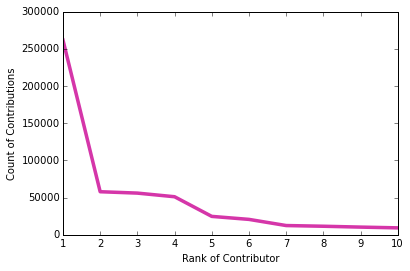

In [4]:
%pylab inline
# Get top 10 contributors
cursor = collection.aggregate([{ "$group": { "_id": "$created.user", 
                                             "count": { "$sum": 1 } } }, 
                               { "$sort": { "count": -1 } }, 
                               { "$limit": 10 }])
top_ten = list(cursor)

# Create x and y axes 
x = list(range(10))
for i in x:
    x[i] += 1 # Because people don't start counting with 0
y = []
for entry in top_ten:
    y.append(entry["count"]) 

# Draw plot
plot(x, y, linewidth=3.5, color="#D536A9")
xlabel("Rank of Contributor")
ylabel("Count of Contributions")
None # prevent plot object output

How many contributors only contributed one time?

In [5]:
cursor = collection.aggregate([{ "$group": { "_id": "$created.user",
                                             "count": { "$sum": 1 } } }, 
                               { "$group": { "_id": "$count", "num_users": { "$sum": 1 } } }, 
                               { "$sort": { "_id": 1 } }, 
                               { "$limit": 1 }])

one_timers = list(cursor)
one_timers

[{u'_id': 1, u'num_users': 77}]

What kind of amenities are in this dataset?

In [6]:
cursor = collection.aggregate([ { "$match": { "amenity": { "$exists": 1 } } },
                                { "$group": { "_id": "$amenity", "count": { "$sum":1 } } },
                                { "$sort": { "count": -1 } },
                                { "$limit": 5 }])
amenities = list(cursor)
amenities

[{u'_id': u'parking', u'count': 806},
 {u'_id': u'restaurant', u'count': 533},
 {u'_id': u'place_of_worship', u'count': 415},
 {u'_id': u'school', u'count': 396},
 {u'_id': u'fast_food', u'count': 276}]

How many nodes contain addresses?

In [7]:
cursor = collection.aggregate([{ "$match": { "type": "node", 
                                             "address": { "$exists": 1 } } }, 
                               { "$group": { "_id": "Addresses",
                                             "count": { "$sum": 1 } } }])
tiger_data = list(cursor)
tiger_data

[{u'_id': u'Addresses', u'count': 368}]

What does the distribution of zip codes look like?

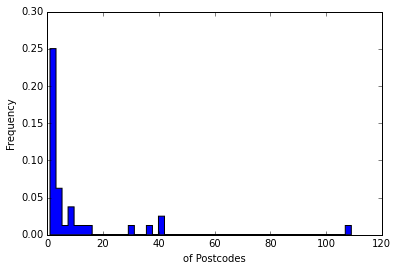

In [46]:
cursor = collection.aggregate([{ "$match": { "address.postcode": { "$exists": 1 } } }, 
                               { "$group": { "_id": "$address.postcode", "count": { "$sum": 1 } } }, 
                               { "$sort": { "count": -1 } }])
postcodes = list(cursor)

x = []
y = []
for entry in postcodes:
    x.append(entry["count"])
    y.append(entry["_id"])

hist(x, 50, histtype="stepfilled", normed=True)
xlabel("of Postcodes")
ylabel("Frequency")

None # prevent plot object output

This graph is a little confusing, but the important part is the distribution.  Most of the postcodes are very closely grouped together, with a few very different ones.  Upon further examination, the extreme outliers appear to be in an altoghther different format. Other postcodes began with `8` or `1` which is incorrect for Virginia.  All Virginia postcodes begin with `2`. 

Next, I will find the most frequent postcode.

In [12]:
cursor = collection.aggregate([{ "$match": { "address.postcode": { "$exists": 1 } } }, 
                               { "$group": { "_id": "$address.postcode", "count": { "$sum": 1 } } }, 
                               { "$sort": { "count": -1 } },
                               { "$limit": 1 }])
postcodes = list(cursor)
postcodes

[{u'_id': u'23223', u'count': 106}]

Now I will update postcodes that do not begin with `2` with the most frequent zip code.

In [42]:
import re
cursor = collection.aggregate([ { "$match": { "address.postcode": { "$exists": 1 } } }, 
                                { "$match": { "address.postcode": { "$not": re.compile("^2") } } } ])
bad_postcodes = list(cursor)

for bad in bad_postcodes:
    id = bad["_id"]
    collection.update(
        {"_id": id},
        {"$set": {"address.postcode": "23223"}}
    )

In [43]:
cursor = collection.aggregate([ { "$match": { "address.postcode": { "$exists": 1 } } }, 
                                { "$match": { "address.postcode": { "$not": re.compile("^2") } } } ])
bad_postcodes = list(cursor)
bad_postcodes

[]

It looks like all of the postcodes now begin with `2`.  Let's see what the count for postcode `23223` is now.

In [47]:
cursor = collection.aggregate([{ "$match": { "address.postcode": { "$exists": 1 } } }, 
                               { "$group": { "_id": "$address.postcode", "count": { "$sum": 1 } } }, 
                               { "$sort": { "count": -1 } },
                               { "$limit": 1 }])
postcodes = list(cursor)
postcodes

[{u'_id': u'23223', u'count': 109}]

Three postcodes have been updated.

## Problems with the Data

I went through several location choices before I settled on Richmond, Virginia. My first choice of locations was far too small to meet the file size requirement for this project. Then, I chose another location with a large enough file size, but it was not very interesting because there were no buildings or amenites at all, only streets.  Then I tried a major city, but my computer crashed when I tried to read the xml file.  Finally, I settled on Richmond which was a good compromise between complexity of the data and smaller file size.  

Unfortunately, this particular data set is relatively cleaner than the other datasets I started analyzing.  For example, there were no unexpected street names, which was not the case with the other datasets. By far, most of the nodes in this dataset do not include addresses or amenities.

When determining whether the `k` values included in the tags would make appropriate MongoDB keys, I found this, `{'k': 'commit message', 'v': '#osmgeoweek #GisNova'}` three times. It appears to include a user name. And a reference to [osmgeoweek](http://osmgeoweek.org/), a geography awareness organization located in Washington, D.C.  It does not appear to have any meaning to the area of Richmond, Virginia.

There are many tag keys that appear once or a very small number of times. For instance, `diet:gluten_free` and `service:bicycle_repair` appear only once each.

Some of the data is encoded according to the [TIGER](http://wiki.openstreetmap.org/wiki/TIGER) system and some is encoded according to the [GNIS](http://wiki.openstreetmap.org/wiki/USGS_GNIS) system. As far as I understand, they are two competing systems and TIGER is the newer and generally more favored of the two. This data is nearly evenly split between the two encoding systems.


##Conclusion
This dataset could be improved by more thorough cleaning, especially by cross validation with other data sources such as Google Maps. For example, some of the postcodes were obviously wrong.  Some had six digits and some did not begin with `2` which is the correct first digit for Virginia postcodes.  I substituted the most popular postcode for some of the obviously incorrect ones, but it would have been better to discern the correct postcode by cross validating with another data source using the position information.

I had trouble analyzing some of the larger datasets on my personal computer. It would be interesting to examine this data using cloud computing clusters, which would facilitate analysis of much larger datasets.  Although that would add more complexity to the analysis, it might prove to be an easier way to validate the data against other sources.

Finally, by utilizing other data sources, it might be possible to discern a better system of tag keys.  The high number of keys appearing only once could possibly be grouped with other keys into slightly broader categories without losing much information.

##Sources
- [Mongo University](https://university.mongodb.com/)
- [Stack Overflow](http://stackoverflow.com/questions/19384871/aggregation-with-update-in-mongodb)
- [Data Wrangling with MongoDB](https://www.udacity.com/course/data-wrangling-with-mongodb--ud032-nd)